# Mountaincar Environment
* Eval can start anywhere from left to goal state, vel 0 (also training). They need 71 episodes
* Modify cartpole to only have two actions-> left and right. The magnitude of the actions are much larger in nfq paper
* Hint to goal, which sometimes makes the agent perform worse
* Group: the magnitude of the action
* Made the forces symmetric

In [1]:
import configargparse
import torch
import torch.optim as optim
import sys
sys.path.append('../')

from environments import MountainCarEnv, Continuous_MountainCarEnv
from models.agents import NFQAgent
from models.networks import NFQNetwork, ContrastiveNFQNetwork
from util import get_logger, close_logger, load_models, make_reproducible, save_models
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
import tqdm
import json
from train_mountaincar import fqi, warm_start, transfer_learning
import scipy
import json


# Running experiments

## "Structureless Test"
* The dynamics of the systems are actually the same. Does CFQI learn a difference?

0


  0%|          | 1/1501 [00:03<1:15:14,  3.01s/it]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


  1%|          | 11/1501 [00:10<23:21,  1.06it/s] 

FREEZING SHARED
FG Trained


Evaluation bg: 100.0 Evaluation fg: 100.0
1


  0%|          | 1/1501 [00:01<25:32,  1.02s/it]

Evaluation bg: [100, 100, 100, 100, 100] Evaluation fg: [100, 100, 100, 100, 100]


  1%|          | 16/1501 [00:11<18:19,  1.35it/s]

FREEZING SHARED
FG Trained


Evaluation bg: 100.0 Evaluation fg: 100.0
2


  0%|          | 1/1501 [00:00<22:02,  1.13it/s]

Evaluation bg: [100, 100, 100, 100, 100] Evaluation fg: [100, 100, 100, 100, 100]


  0%|          | 2/1501 [00:01<22:32,  1.11it/s]

FREEZING SHARED
FG Trained


Evaluation bg: 100.0 Evaluation fg: 100.0
3


  0%|          | 1/1501 [00:02<1:07:33,  2.70s/it]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


  2%|▏         | 24/1501 [00:20<21:04,  1.17it/s] 

FREEZING SHARED
FG Trained


Evaluation bg: 100.0 Evaluation fg: 100.0


/home/amandyam/.conda/envs/research/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/amandyam/.conda/envs/research/lib/python3.6/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/amandyam/.conda/envs/research/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/amandyam/.conda/envs/research/lib/python3.6/site-p

Text(0.5, 1.0, 'Dynamics are the same in fg and bg environments')

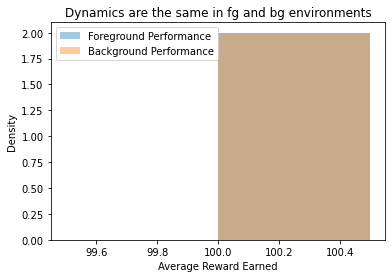

In [2]:
import json
from train_mountaincar import fqi, warm_start, transfer_learning
num_iter=4
perf_foreground = []
perf_background = []
for i in range(num_iter):
    print(str(i))
    perf_bg, perf_fg = fqi(epoch=1500, gravity=0.0025, verbose=True, is_contrastive=True, structureless=True, hint_to_goal=False)
    perf_foreground.append(perf_fg)
    perf_background.append(perf_bg)
sns.distplot(perf_foreground, label='Foreground Performance')
sns.distplot(perf_background, label='Background Performance')
plt.legend()
plt.xlabel("Average Reward Earned")
plt.title("Dynamics are the same in fg and bg environments")

## "Performance when force left is different"
* We change the gravity on the foreground environments. 

In [ ]:
num_iter=2
results = {}
for i in range(0, 5):
    results[i] = {}
    results[i]['cfqi'] = {}
    results[i]['fqi'] = {}
    results[i]['warm_start'] = {}
    results[i]['transfer_learning'] = {}
    
initial_g = 0.0025
for i in range(num_iter):
    for f in range(0, 5):
        gravity = initial_g + f*0.0005
        print(str(gravity))
        perf_bg, perf_fg = fqi(epoch=1500, verbose=False, is_contrastive=True, structureless=True, gravity=gravity, deep=True, hint_to_goal=False)
        results[f]['cfqi'][i] = (perf_fg, perf_bg)
        
        perf_bg, perf_fg = fqi(epoch=1500, verbose=False, is_contrastive=False, structureless=True, gravity=gravity, deep=True, hint_to_goal=False)
        results[f]['fqi'][i] = (perf_fg, perf_bg)
        
        perf_bg, perf_fg = warm_start(epoch=1500, verbose=False, structureless=True, gravity=gravity)
        results[f]['warm_start'][i] = (perf_fg, perf_bg)
        
        perf_bg, perf_fg = transfer_learning(epoch=1500, verbose=False, structureless=True, gravity=gravity)
        results[f]['transfer_learning'][i] = (perf_fg, perf_bg)
        
        
        
        
    with open('gravity_v_performance.json', 'w') as f:
        json.dump(results, f) 

In [ ]:
results

In [ ]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

def plot_performance(results, x, ds='bg'):
    c_success = []
    f_success = []
    w_success = []
    t_success = []
    c_errs = []
    f_errs = []
    w_errs = []
    t_errs = []
    if ds == 'bg':
        ind = 1
    else:
        ind = 0
    for i in range(0, 5):
        cfqi_perf = []
        fqi_perf = []
        ws_perf = []
        tl_perf = []
        for key in results[i]['fqi']:
            fqi_perf.append(results[i]['fqi'][key][ind])
        for key in results[i]['cfqi']:
            cfqi_perf.append(results[i]['cfqi'][key][ind])
        for key in results[i]['warm_start']:
            ws_perf.append(results[i]['warm_start'][key][ind])
        for key in results[i]['transfer_learning']:
            tl_perf.append(results[i]['transfer_learning'][key][ind])

        c_success.append(np.mean(cfqi_perf))
        f_success.append(np.mean(fqi_perf))
        w_success.append(np.mean(ws_perf))
        t_success.append(np.mean(tl_perf))
        m, h = mean_confidence_interval(cfqi_perf)
        c_errs.append(h)
        m, h = mean_confidence_interval(fqi_perf)
        f_errs.append(h)
        m, h = mean_confidence_interval(ws_perf)
        w_errs.append(h)
        m, h = mean_confidence_interval(tl_perf)
        t_errs.append(h) 

    plt.figure(figsize=(10, 4))
    sns.scatterplot(x, c_success, label='CFQI')
    plt.errorbar(x, c_success ,yerr=c_errs, linestyle="None")
    sns.scatterplot(x, f_success, label='FQI')
    plt.errorbar(x, f_success ,yerr=f_errs, linestyle="None")
    sns.scatterplot(x, w_success, label='Warm Start')
    plt.errorbar(x, w_success ,yerr=w_errs, linestyle="None")
    sns.scatterplot(x, t_success, label='Transfer Learning')
    plt.errorbar(x, t_success ,yerr=t_errs, linestyle="None")
    if ds == 'bg':
        plt.title("Background Dataset: Performance of CFQI, FQI, Warm Start, Transfer Learning when gravity is modified")
    else:
        plt.title("Foreground Dataset: Performance of CFQI, FQI, Warm Start, Transfer Learning when gravity is modified")
    plt.xlabel("Gravity")
    plt.ylabel("Reward")
    plt.show()  

In [ ]:
initial_gravity = 0.0025
x = []
for i in range(5):
    x.append(initial_gravity + i*0.005)
plot_performance(results, x, ds='bg')

## Group imbalance test

In [ ]:
num_iter = 2
results = {}

GRAVITY = 0.004

total_samples = 400
fg_sample_fractions = [0.1 * x for x in np.arange(1, 6)]

for i in fg_sample_fractions:
    results[i] = {}
    results[i]["fg_only"] = {}
    results[i]["cfqi"] = {}
    results[i]["fqi_joint"] = {}
    
for i in range(num_iter):

    for fg_sample_fraction in fg_sample_fractions:

        n_fg = int(total_samples * fg_sample_fraction)
        n_bg = int(total_samples - n_fg)
        
        # Only train/test on small set of foreground samples
        perf_bg, perf_fg = fqi(epoch=1500, verbose=False, is_contrastive=True, structureless=False, gravity=GRAVITY, fg_only=True, init_experience_bg=n_fg // 2,
            init_experience_fg=n_fg // 2)
        results[fg_sample_fraction]["fg_only"][i] = (perf_bg, perf_fg)

        # Use contrastive model with larger pool of background samples
        perf_bg, perf_fg = fqi(epoch=1500, is_contrastive=True,init_experience_bg=n_bg,init_experience_fg=n_fg,fg_only=False,verbose=False,gravity=GRAVITY)
        results[fg_sample_fraction]["cfqi"][i] = (perf_bg, perf_fg)

        # Use non-contrastive model with larger pool of background samples
        perf_bg, perf_fg = fqi(is_contrastive=False,init_experience_bg=n_bg,init_experience_fg=n_fg,fg_only=False,gravity=GRAVITY,epoch=1500,verbose=False,)
        results[fg_sample_fraction]["fqi_joint"][i] = (perf_bg, perf_fg)

        with open("class_imbalance_cfqi.json", "w") as f:
            json.dump(results, f)


In [ ]:
results